# Patch Removal Demo

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from train_main import CIFAR10Classifier
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math
from scipy.ndimage.interpolation import rotate
from AddPatch import AddPatch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


C:\Users\bill_\AppData\Local\Temp\ipykernel_37232\13163418.py:11: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


## Load CIFAR 10 Dataset with Adversarial Patches

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    AddPatch(32, 0.1, "./toster_patch.png"),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

batch_size = 8

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img, out_path):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    
    npimg = np.transpose(npimg * 255, (1, 2, 0))
    npimg = npimg.astype("uint8")
    # plt.imshow(npimg)
    img = Image.fromarray(npimg, "RGB")
    img.save(out_path)

Files already downloaded and verified


### Plot Sample images

In [3]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images), "./plots/original_images.png")

## Load ResNet18 model

In [2]:

# load model
model = CIFAR10Classifier.load_from_checkpoint("experiment_results/resnet18-2022-12-08-17-10/version_0/checkpoints/epoch=49-step=54700.ckpt")
model.eval()
model.to(device)
# print(model)

c:\Users\bill_\anaconda3\envs\cv\lib\site-packages\torchvision\transforms\transforms.py:899: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


CIFAR10Classifier(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

## Test models Accuracy Without Defense

In [4]:
total_count = 0
correct_count = 0

# Here, we use enumerate(training_loader) instead of
# iter(training_loader) so that we can track the batch
# index and do some intra-epoch reporting
with torch.no_grad(): 
    for i, data in enumerate(testloader):
        # Every data instance is an input + label pair
        inputs, labels = data
        labels = labels.squeeze()

        inputs = inputs.to(device)
        logits = model(inputs)
        logits = model(inputs).to("cpu")
        preds = torch.argmax(logits, dim=1)
        

        correct = preds == labels

        total_count += len(labels)
        correct_count += torch.sum(correct)


print("Number of samples:", total_count, "\tCorrect:", int(correct_count), "\tAccuracy:", float(correct_count / total_count))



Number of samples: 10000 	Correct: 6439 	Accuracy: 0.6438999772071838


## Test Patch Removal Defense  

In [7]:
from local_gradients_smoothing.configs.configure import Configuration
from local_gradients_smoothing.lgs.local_gradients_smoothing import LocalGradientsSmoothing

acc_list = []
# threshold_list = np.linspace(0.3, 1, num=30)
threshold_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
patch_size_list = [0.03, 0.05, 0.07, 0.1, 0.13, 0.15, 0.17, 0.2]

threshold = 1

for threshold in [0.3]:

    # transform = transforms.Compose([
    # transforms.ToTensor(),
    # AddPatch(32, patch_size, "./toster_patch.png"),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # ])

    # batch_size = 1

    # # trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    # # trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    # testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    # testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    cfg = {'smoothing_factor': 2.3,
        'window_size': 2,
        'overlap': 1,
        'threshold': threshold,
        'grad_method': "Gradient"
        }
    loc_grad_smooth = LocalGradientsSmoothing(**cfg)

    # show images
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images_shape = images.shape

    masks = torch.zeros_like(images)
    grads = torch.zeros((images_shape[0], 1, images_shape[2], images_shape[3]))
    imshow(torchvision.utils.make_grid(images), "./plots/patched_images" + ".png")
    for i in range(len(images)):
        grad_mask = loc_grad_smooth.normalized_grad(images[i]).squeeze()
        grad_mask = torch.mean(grad_mask, dim=0, keepdim=True)
        
        grads[i] = grad_mask
        
        grad_mask = grad_mask.repeat((3, 1, 1))
        masks[i][grad_mask > threshold] = 1
        masks[i][grad_mask <= threshold] = 0
        
        images[i] = images[i] * (1 - masks[i])
        

    imshow(torchvision.utils.make_grid(images), "./plots/filtered_images" + str(threshold).replace(".", "_") + ".png")
    imshow(torchvision.utils.make_grid(masks), "./plots/mask_images" + str(threshold).replace(".", "_") + ".png")
    imshow(torchvision.utils.make_grid(grads), "./plots/grad_images" + str(threshold).replace(".", "_") + ".png")

    total_count = 0
    correct_count = 0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    with torch.no_grad(): 
        for i, data in enumerate(testloader):
            # Every data instance is an input + label pair
            inputs, labels = data
            labels = labels.squeeze()

            for j in range(len(inputs)):
                
                grad_mask = loc_grad_smooth.normalized_grad(inputs[j]).squeeze()
                grad_mask = torch.mean(grad_mask, dim=0, keepdim=True)

                grad_mask = grad_mask.repeat((3, 1, 1))
                grad_mask[grad_mask > threshold] = 1
                grad_mask[grad_mask <= threshold] = 0
                
                inputs[j] = inputs[j] * (1 - grad_mask)

                # # img_t = transforms.ToTensor()(inputs)
                # collage_t = torch.cat([inputs[0], grad_mask, inputs[0] * (1 - grad_mask)], dim=-1)
                # collage = transforms.ToPILImage()(collage_t)
                # collage.show()
                # result_path = cfg.get('TESTING')['result_path']
                # collage.save(result_path)
            inputs = inputs.to(device)
            logits = model(inputs).to("cpu")
            preds = torch.argmax(logits, dim=1)

            correct = preds == labels

            
            total_count += len(labels)
            correct_count += torch.sum(correct)

        print(threshold, "- Number of samples:", total_count, "\tCorrect:", int(correct_count), "\tAccuracy:", float(correct_count / total_count))
        acc_list.append(float(correct_count / total_count))

np.savez("./acc.npz", patch_size_list, acc_list)

[0.03 0.05 0.07 0.1  0.13 0.15 0.17 0.2 ]


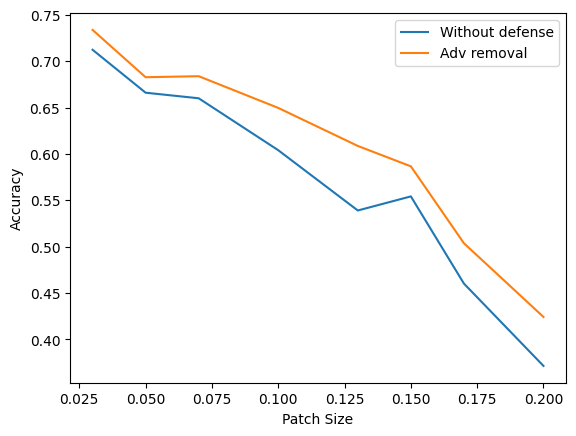

In [4]:
import numpy as np
import matplotlib.pyplot as plt

npzfile = np.load("./acc.npz")
npzfile1 = np.load("./def_acc_vs_patch_size.npz")
print(npzfile["arr_0"])

plt.plot(npzfile["arr_0"], npzfile["arr_1"], label="Without defense")
plt.plot(npzfile1["arr_0"], npzfile1["arr_1"], label="Adv removal")
plt.xlabel("Patch Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()